In [1]:
!pip install -e ../CauseML

Obtaining file:///home/jovyan/work/CauseML
  Found existing installation: cause-ml 0.0.11
    Uninstalling cause-ml-0.0.11:
      Successfully uninstalled cause-ml-0.0.11
  Running setup.py develop for cause-ml


In [3]:
%load_ext autoreload
%autoreload 2
from cause_ml.parameters import build_parameters_from_metric_levels
from cause_ml.constants import Constants
from cause_ml.data_generation import DataGeneratingProcessWrapper
import cause_ml.data_sources as data_sources
from cause_ml.utilities import extract_treat_and_control_data
from cause_ml.data_metrics import calculate_data_metrics

In [4]:
from collections import defaultdict
from IPython.display import clear_output
import matplotlib.pyplot as plt

## 1. Demonstration of Basic Dataset Generation Workflow

The code below demonstrates how the various pieces of CauseML benchmarking work together to generate a synthetic dataset.

1. Covariate data is fetched from the random covariate data source (imported above).


2. Parameters are generated by setting some metrics to given levels (with the rest left at default).


3. A data generating process is sampled according to the parameters and this DGP is used to generate data.


4. The observed and oracle data is extracted from the DGP wrapper. The observed data corresponds to the data a model would run on: the observed covariates, treatment assignment and outcome. The oracle data contains the potential outcomes and the transformed covariates which make up the treatment and outcome functions. Throughout this notebook, these transformed covariates are referenced as the 'True Covariates'. This is because a simple linear model over these values would accurately model the treatment and response surfaces.

In [5]:
covar_data_source = data_sources.load_random_normal_covariates(n_covars = 5, n_observations=100)
# covar_data_source = data_sources.load_cpp()

In [6]:
covar_data = covar_data_source.get_data()
print(covar_data.shape)
covar_data.head()

(100, 5)


,X0,X1,X2,X3,X4
0,0.152324,-0.003355,0.636433,0.694367,-0.621935
1,0.781068,-0.471260,-0.028661,-0.283387,0.688606
2,-0.278689,0.320466,0.098122,0.278765,-0.626023
3,0.004763,0.144705,0.323974,-0.222392,-0.363997
4,0.888957,-0.508326,0.714334,-0.318887,0.385126


In [7]:
dgp_params = build_parameters_from_metric_levels({
    Constants.AxisNames.TREATMENT_NONLINEARITY: Constants.AxisLevels.HIGH,
    Constants.AxisNames.TE_HETEROGENEITY: Constants.AxisLevels.LOW
})

In [8]:
%%time

dgp_wrapper = DataGeneratingProcessWrapper(
    parameters=dgp_params, data_source=covar_data_source)

dgp_wrapper.sample_dgp()

CPU times: user 200 ms, sys: 0 ns, total: 200 ms
Wall time: 198 ms


In [9]:
%%time

_ = dgp_wrapper.generate_dataset()

CPU times: user 380 ms, sys: 0 ns, total: 380 ms
Wall time: 382 ms


In [10]:
obs = dgp_wrapper.get_observed_data()
oracle = dgp_wrapper.get_oracle_data()

In [11]:
obs.head()

,T,Y,X0,X1,X2,X3,X4
75,0,0.784132,-0.376234,0.842273,-0.408058,0.036607,-0.709303
6,1,1.402287,0.859438,0.190697,-0.489713,-0.005764,-0.151992
86,0,-2.358923,0.239632,0.126935,-0.271337,-0.673391,0.300139
62,0,-0.108338,-0.269299,0.412401,0.233084,1.000000,-0.839044
84,1,0.249866,-0.222109,0.104935,0.069743,-0.434045,0.041327


In [12]:
oracle.head()

,logit(P(T|X)),P(T|X),Y0,Y1,TE,TRANSFORMED_X0,TRANSFORMED_X1,TRANSFORMED_X2,TRANSFORMED_X3,TRANSFORMED_X4,...,TRANSFORMED_X12,TRANSFORMED_X13,TRANSFORMED_X14,TRANSFORMED_X15,TRANSFORMED_X16,TRANSFORMED_X17,TRANSFORMED_X18,TRANSFORMED_X19,TRANSFORMED_X20,NOISE(Y)
75,0.103345,0.525813,0.784132,0.841132,0.057,0.001592,0.000175,0.012677,0.000944,-0.016239,...,0.013076,0.003386,0.007241,0.013314,0.000,-0.032831,-0.124269,-0.001311,0.026753,0.288
6,1.150579,0.759617,1.345287,1.402287,0.057,0.000123,-0.000001,0.000738,-0.000040,-0.028069,...,-0.006401,-0.007735,-0.004495,0.003424,0.000,-0.000323,-0.005706,-0.000107,0.139602,0.339
86,-2.091427,0.109933,-2.358923,-2.301923,0.057,-0.007894,0.000205,-0.000538,-0.001739,-0.004774,...,0.003524,-0.002157,-0.000462,-0.003746,0.036,0.002487,-0.022251,-0.002315,0.010853,-0.086
62,-1.327834,0.209518,-0.108338,-0.051338,0.057,0.036831,0.002768,-0.004194,-0.007209,0.003026,...,0.011072,0.002424,-0.001450,-0.008996,0.000,-0.054343,-0.173887,-0.012550,0.013707,-0.070
84,0.104054,0.525990,0.192866,0.249866,0.057,0.000649,0.000015,0.000016,0.000238,0.000081,...,-0.000450,0.001999,-0.000091,0.000133,0.036,0.000006,-0.000422,0.001143,0.009324,0.061


In [21]:
id(dgp_wrapper.observed_covariate_data)

a = dgp_wrapper.observed_covariate_data
b = dgp_wrapper.observed_covariate_data

id(a), id(b)

(139786067539056, 139786067539056)

## 2. Metrics and Measures

The code below displays the various metrics which specify the distributional challenges in the data and the measures used to quantify them.

Note that most of the measures below are what is referred to as Oracle measures. They are not values we could calculate in real observational data as they rely on access to data about the counterfactual outcome and assignment mechanism.

#### 1. Outcome Nonlinearity

This is the degree of non-linearity in the outcome mechanism. It is measured as the linear fit $R^2$ between the observed covariates and the observed outcome. The higher the $R^2$, the more linear the outcome surface must be. This is not an oracle measure.

#### 2. Treatment Nonlinearity

This is the degree of non-linearity in the treatment mechanism. It is measured as the linear fit $R^2$ between the observed covariates and the logit of the propensity score. The higher the $R^2$, the more linear the treatment surface must be. This is an oracle measure as the propensity score and its logit is unknown in normal circumstances.

#### 3. Percent Treated

This is the percent of the dataset in the treated condition. It is a simple non-oracle measure.

#### 4. Balance

Three measures are used to quantify balance.

The simplest is the distance between the means of the true covariates in the two groups (see above for a definition of the true covariates). If the distributions are identical, the means will be in the same location. The problem with this measure is that it is sensitive to outliers or dimensions with higher variance (which can pull the mean far apart even if most dimensions have very similar values). This is a non-oracle metric.

The second simplest measure is the naive error in the average treatment effect estimate. In balance data, the ATE should be accurate. In imbalanced data it will not be. This is an oracle metric as it relies on access to the true ATE.

Finally, the Wassertein distance is used. This will be discussed more in future work but it is an integral probability measure of distance (the sum of the distance between the distribution CDFs across the domain) which means it is a pretty good measure of distance. 

#### 5. Alignment

The alignment measures the correlation ($R^2$) between the outcome and the the propensity logit. The higher this value, the greater the degree of confounding as the covariates which affect the outcome affect the assignment "more". This is an oracle metric as it relies on the propensity logit.

#### 6. Treatment Effect Heterogeneity

This measures the degree to which the treatment effect interacts with covariates (changes per individual). The standard deviation in the treatment effect is normalized by the standard deviation in the outcome so that the only variation measured is in the treatment effect itself (rather than changes coming from the base response function and not the interacion terms).


In [13]:
metrics_and_measures = {
#     Constants.AxisNames.OUTCOME_NONLINEARITY: [
#         "Lin r2(X_obs, Y)"
#     ],
    Constants.AxisNames.TREATMENT_NONLINEARITY: [
        "Lin r2(X_obs, Treat Logit)"
    ],
#     Constants.AxisNames.PERCENT_TREATED: [
#         "Percent(T==1)"
#     ],
#     Constants.AxisNames.BALANCE: [
# #         "Mean dist X_true: T=1<->T=0",
#         "Wass dist X_true: T=1<->T=0",
# #         "Naive TE"
#     ],
#     Constants.AxisNames.ALIGNMENT: [
#         "Lin r2(Y, Treat Logit)",
#         "Lin r2(Y0, Treat Logit)"
#     ],
#     Constants.AxisNames.TE_HETEROGENEITY: [
#         "std(TE)/std(Y)"
#     ]
}

levels = [
    Constants.AxisLevels.LOW,
    Constants.AxisLevels.MEDIUM,
    Constants.AxisLevels.HIGH,
]

## 3. Parameter Validation

The code below generates 30 datasets from 10 covariates for each possible setting (high, medium, low) of each metric and plots the distribution of the measures of each metric at each level. Each metric setting corresponds to different underlying parameters, so this serves as a validation that the parameter settings do indeed produce the desired effect on the relevant metric.

Each of the plots show a clear correspondence betweent the metric/parameter setting and the metric measures which track the realized level of the metric in the simulated data. The exact values of the metrics also agrees with the medians and quartiles stipulated in Dorie et al (2019)

There are two metrics worth exploring in a little more detail. Firstly, not that only the middle metric measure in Balance appears to accurately capture the increasing imbalance. Measuring balance is - in general - a hard problem. The Wassertein distance between the true covariates in the treat and control group is a promising measure based on the summed absolute error between the distribution CDFs. I plan to spend some time discussing this distance measure in the final draft.

Also note that the measure of treatment effect heterogeneity has a very wide distribution. This is because the distribution used to generate the treatment effect itself has thick tails. This means that there is large variance in the treatment effect size and hence large variance in the impact of the interactions with covariates. I plan to refine this soon.

In [18]:
%%time

results = analyze_metric_measures_across_levels(
    metrics_and_measures,
#     lambda: data_sources.load_random_normal_covariates(n_covars = 10, n_observations=100),
#     data_sources.load_cpp,
    data_sources.load_lalonde,
    n_trials=50)


Running for TREATMENT_NONLINEARITY. Level:  LOW MEDIUM HIGH CPU times: user 2min 31s, sys: 53.4 s, total: 3min 24s
Wall time: 2min 2s


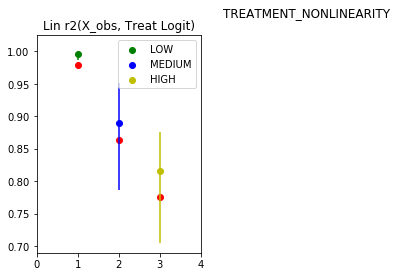

In [19]:
plot_metric_measure_analysis(results, max_measure_count=3, mean=True, min_max=False)

In [15]:
def analyze_metric_measures_across_levels(
    metrics_and_measures, covar_generator,
    n_trials=20):
    '''
    Collect values for the given metrics and measures
    across all possible settings for each metric. Uses
    the gather_metric_measures_for_given_params to generate
    the metric measure values.
    '''

    results = defaultdict(lambda: defaultdict(dict))
    
    # Run for each given metric and set of measures
    for metric, measures in metrics_and_measures.items():
        print(f"\nRunning for {metric}. Level: ", end=" ")

        # Construct observation list of measures.
        observation_list = { metric: measures }

        # Run trials at all levels of metric.
        for level in levels:
            print(level, end=" ")
            dgp_params = build_parameters_from_metric_levels({
                metric: level
            })

            res = gather_metric_measures_for_given_params(
                    dgp_params, observation_list, covar_generator,
                    n_trials=n_trials)
            
            for measure, values in res[metric].items():
                results[metric][measure][level] = values
    
    return results

In [16]:
def gather_metric_measures_for_given_params(
        dgp_params, observation_spec,
        covar_generator,
        n_trials=10, verbose=False):
    
    '''
    Create n_trials datasets by sampling data generating processes according
    to the given dgp_params and data source parameters (n_covars, n_obs).
    
    Collect the metrics given in observation spec.
    '''
    results = defaultdict(lambda: defaultdict(list))
    for i in range(n_trials):
        if verbose:
            clear_output()
            print("Trials run:", i+1)
        results
        
        # Generate data
        data_source = covar_generator()
        
        # Sample DGP
        dgp_wrapper = DataGeneratingProcessWrapper(
            parameters=dgp_params, data_source=data_source)
        dgp_wrapper.sample_dgp()
        observed_covariate_data, observed_outcome_data, oracle_covariate_data, oracle_outcome_data = \
            dgp_wrapper.generate_dataset()
        
        # Calculate metrics
        metrics = calculate_data_metrics(
            observed_covariate_data, observed_outcome_data,
            oracle_covariate_data, oracle_outcome_data,
            observation_spec=observation_spec)
        
        # Build results
        for metric, measures in observation_spec.items():
            for measure in measures:
                res = metrics[metric][measure]
                if res is not None:
                    results[metric][measure].append(res)
    
    if verbose:
        for metric, measures in results.items():
            for measure, result_data in measures.items():
                print(f"{metric} {measure}:")
                print("min", round(np.min(result_data), 3), end=" ")
                print("mean:", round(np.mean(result_data), 3), end=" ")
                print("max", round(np.max(result_data), 3))
                print("-------------\n\n")
        
    return results

In [17]:
def plot_metric_measure_analysis(results, max_measure_count=1, mean=False, min_max=False):
    '''
    Plot the results of the analyze_metric_measures_across_levels
    function. Show the median, mean and 1st and 3rd quartiles for each
    metric measure at each level.
    '''
    
    level_colors = ["g", "b", "y"] # low medium high
    mean_color = "r" # mean will be red
    max_min_color = "k" # mean will be red
    for metric, measures in results.items():
        plt.figure(figsize=(10, 4))
        plt.suptitle(f"{metric}")
        plt.tight_layout()

        for measure_num, (measure_name, measure_values) in enumerate(measures.items()):
            plt.subplot(1, max_measure_count, 1 + measure_num)
            plt.title(f"{measure_name}")
            for level_num, level in enumerate(levels):
                level_values = measure_values[level]

                # Find quartile values in data
                quartiles = np.percentile(
                    level_values,
                    [25, 50, 75],
                    interpolation = 'midpoint')

                # Prepare plotting data
                x = level_num+1
                y_median = quartiles[1]
                
                
                err = np.array([
                    [y_median - quartiles[0]],
                    [quartiles[2] - y_median]
                ])

                # Plot
                color = level_colors[level_num]
                plt.xlim((0, max_measure_count+1))
                plt.scatter(x, y_median, label=level, color=color)
                plt.errorbar(x, y_median, err, color=color)
                
                if mean:
                    y_mean = np.mean(level_values)
                    plt.scatter(x, y_mean, color=mean_color)
                
                if min_max:
                    y_max = np.max(level_values)
                    y_min = np.min(level_values)
                    plt.scatter(x, y_max, color=max_min_color)
                    plt.scatter(x, y_min, color=max_min_color)
                
            plt.legend()

        plt.show()